# `reaction-network`: Networks (Demo Notebook 2)

#### <u> Author:</u> Matthew McDermott (_U.C. Berkeley / Lawerence Berkeley National Laboratory_)
Last Updated: 08/31/23

This notebook serves as a walkthrough for **reaction network construction and pathfinding analysis**. If you haven't first explored the enumerator notebook `1_enumerators.ipynb`, we strongly recommend starting there, as it will cover the foundation for how reaction networks are constructed. 

The code provided in this notebook is an updated walkthrough of a case study (YMnO$_3$ synthesis) in the manuscript below. The current version of the `reaction-network` package contains similar functionality as what was originally released with the manuscript; however, much of the code has been drastically improved. If you arrived here looking for the specific results that went into the manuscript, then look at the archived demo notebook in the _archived_ folder or an older Release of the package on Github.

Lastly, if you use this code or Python package in your work, please consider citing the following paper:

    McDermott, M. J., Dwaraknath, S. S., and Persson, K. A. (2021). A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis. Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-23339-x

## 1. Imports

We first import the classes and functions we will need throughout the notebook. If you get an error importing any of these, please make sure you run:

`pip install --upgrade reaction-network` 

`pip install --upgrade mp-api` 

in your terminal to ensure that you have successfully installed the package/dependencies. You may need to restart and reconfigure your Jupyter kernel as well.

In [1]:
import logging 

from mp_api.client import MPRester

from rxn_network.costs.functions import Softplus
from rxn_network.entries.entry_set import GibbsEntrySet
from rxn_network.enumerators.basic import BasicEnumerator, BasicOpenEnumerator
from rxn_network.enumerators.minimize import MinimizeGibbsEnumerator, MinimizeGrandPotentialEnumerator
from rxn_network.network.visualize import plot_network
from rxn_network.network.network import ReactionNetwork
from rxn_network.pathways.solver import PathwaySolver
from rxn_network.reactions.computed import ComputedReaction

# this is useful if you are editing the code locally!
%load_ext autoreload 
%autoreload 2

# Case Study: YMnO3 assisted metathesis
### Background

We will be using the assisted metathesis synthesis of YMnO$_3$ as a case study for the reaction network code. This is the first example discussed in the original manuscript. The assisted metathesis reaction reported by [Todd & Neilson (JACS, 2019)](https://pubs.acs.org/doi/full/10.1021/jacs.8b10123) corresponds to a net reaction of:

$$ \text{Mn}_2\text{O}_3 + 2\ \text{YCl}_3 + 3\ \text{Li}_2\text{CO}_3 \to 2\ \text{YMnO}_3 + 6\ \text{LiCl} + 3\ \text{CO}_2 $$

This is a powder reaction involving three solid precursors, which suggests there might be some intermediate reactions here worth identifying. This is seen experimentally. 

In the paper, they report a reaction pathway involving the formation of key intermediates LiMnO$_2$ and YOCl. These react to form YMnO$_3$ product and LiCl byproduct. The pathway seen experimentally looks something like this:

$$\ce{Li2CO3 + Mn2O3 -> 2\ LiMnO2 + CO2}$$
$$\ce{YCl3 + Li2CO3 -> YOCl + 2\ LiCl + CO2}$$
$$\ce{LiMnO2 + YOCl -> YMnO3 + LiCl}$$

Due to carbonate decomposition, $\ce{Li2O}$ may exist in place of $\ce{Li2CO3}$.

## 2. Acquiring thermodynamic data from the Materials Project

As we did in the previous notebook, we first acquire entries for phases in the system of interest (Y-Mn-O-Li-Cl-C). We do this by querying the Materials Project (MP), a computed materials database containing calculations for over 150,000 materials:

In [2]:
with MPRester() as mpr:  # insert your Materials Project API key in the parentheses or configure elsewhere; see mp-api for more info.
    entries = mpr.get_entries_in_chemsys("Y-Mn-O-C-Cl-Li")

Retrieving ThermoDoc documents:   0%|          | 0/919 [00:00<?, ?it/s]

Previously we showed that the `GibbsEntrySet` class allows us to automatically convert `ComputedStructureEntry` objects downloaded from the MP database into `GibbsComputedEntry` objects, where DFT-calculated energies have been converted to machine learning (ML)-estimated equivalent values of the Gibbs free energies of formation, $\Delta G_f$, for all entries at the specified temperature. This also mixes in experimental thermochemistry data (e.g., from NIST-JANAF).

For more information, check out the citation in the documentation for `GibbsComputedEntry`.

In [3]:
temp = 900  # synthesis temperature of interest in Kelvin
entry_set = GibbsEntrySet.from_computed_entries(entries, temp)

We can use the `filter_by_stability()` function to automatically remove metastable entries above a certain energy threshold. This will dramatically decrease the combinatorial complexity of our space.

In [4]:
filtered_entries = entry_set.filter_by_stability(0.00)  # use only stable phases (i.e., 0 eV/atom threshold)

print(f"{len(entry_set)} (unfiltered) -> {len(filtered_entries)} (filtered)")

798 (unfiltered) -> 46 (filtered)


In this case, we remove all entries which are unstable (above an energy cutoff of 0.0 meV/atom). Typically, you will want this number to be greater than zero. A good range is somewhere between 0.0 to 0.100 eV/atom. See [this paper](https://www.science.org/doi/10.1126/sciadv.aaq0148) for more information on energy thresholds for metastability.

## 3. Building the reaction network

To build a reaction network, we need to first enumerate a set of reactions. Please see the first notebook (`1_enumerators.ipynb`) for more information on reaction enumeration.

We will use a BasicEnumerator to get all reactions in the Y-Mn-O-C-Li-Cl system up to <=2 reactants or products:

In [5]:
be = BasicEnumerator()

In [6]:
rxns = be.enumerate(filtered_entries)  # this will take a few seconds

2023-08-31 12:13:03,541 INFO rxn_network.utils.ray Ray is not initialized. Checking for existing cluster...
2023-08-31 12:13:03,541 INFO rxn_network.utils.ray Could not identify existing Ray instance. Creating a new one...


2023-08-31 12:13:05,215	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 


2023-08-31 12:13:05,683 INFO rxn_network.utils.ray HOST: matts-mbp.lan.vpn-dhcp.lbl.gov, Num CPUs: 12.0, Total Memory: 51734973645.0


Building chunks...: 100%|██████████████████| 57/57 [00:00<00:00, 2275.11it/s]
Enumerating reactions (BasicEnumerator): 100%|█| 12/12 [00:02<00:00,  4.49it/


We identified a few thousand reactions:

In [7]:
print(len(rxns))

2914


Finally, before we can create a reaction network, we must specify how to assign weights to the edge of the network. 

The "cost function" is a monotonic function used to assign edge weights. In this case, we will use the softplus function (as in the original paper), assigned a temperature scaling of $T=900$ K with default arguments. This automatically converts the `energy_per_atom` of the reactions to positive cost values:

In [8]:
cf = Softplus(temp=900)

For example, here is how it transforms the energies to costs for a few reactions:

In [9]:
for idx, r in enumerate(rxns):
    print(r, " |  ", round(r.energy_per_atom, 4), "eV/atom ->", round(cf.evaluate(r), 4), "(cost, a.u.)")
    if idx >= 3:
        break

YClO + CO2 -> YCCl + 1.5 O2  |   1.5728 eV/atom -> 0.901 (cost, a.u.)
YCCl + 1.5 O2 -> YClO + CO2  |   -1.5728 eV/atom -> 0.061 (cost, a.u.)
YCCl + 0.5 CO2 -> YClO + 1.5 C  |   -0.7298 eV/atom -> 0.1365 (cost, a.u.)
YClO + 1.5 C -> YCCl + 0.5 CO2  |   0.7298 eV/atom -> 0.4882 (cost, a.u.)


We are now ready to build a reaction network from our reactions. To do this, we first initialize a `ReactionNetwork` object:

In [10]:
rn = ReactionNetwork(rxns, cf)

Initialization does not build the network graph. To do so, we must call the `.build()` function, which runs in-place:

In [11]:
rn.build()

2023-08-31 12:13:08,665 INFO rxn_network.network.network Building graph from reactions...


100%|██████████████████████████████████| 2914/2914 [00:01<00:00, 1922.52it/s]


2023-08-31 12:13:10,461 INFO rxn_network.network.network Built graph with 1194 nodes and 3511 edges


This should have completed within a few seconds. A weighted graph object is built using the `rustworkx` and stored under the `graph` attribute of the reaction network object.

We can access this graph object by using the `graph` attribute:

In [12]:
rn.graph

<rxn_network.network.network.Graph object at 0x2a203d630> with 1194 nodes and 3511 edges

**Plotting:** There are many ways to plot reaction networks. The easiest is to use the built in `mpl_draw` function from rustworkx, which has been provided in a wrapper function.

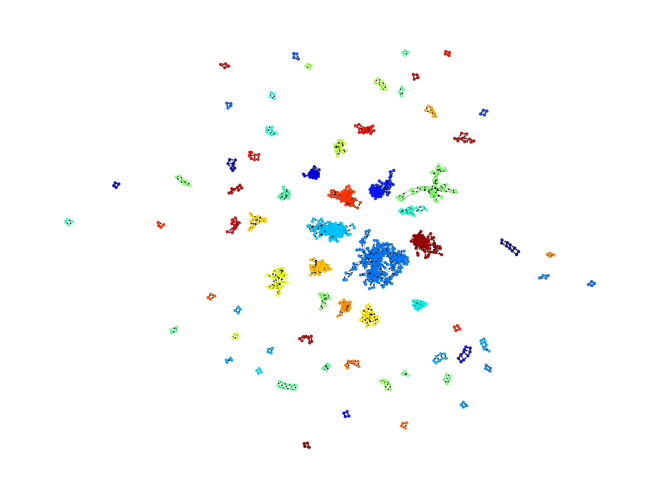

In [13]:
plot_network(rn.graph);

You'll notice that at this stage, the reaction network graph is a collection of "sub"-networks, i.e. a collection of smaller reaction networks for smaller chemical subsystems. This configuration will change once we set up for pathfinding in the next section.

Alternative ways of plotting networks will not be covered in this notebook; however, any graph plotting tool that takes in Python network objects should theoretically work with the right customization settings.

## 4. Identifying reaction pathways using pathfinding and balancing/solving

To identify reaction pathways, we must first set the starting point (precursor phases) and ending point (target) phase. 

This will automatically build all the required "zero-cost" edges which connect the different chemical subsystems. Please see the original manuscript for more details on how this is completed.

In summary, zero-cost "loopback" edges are drawn from a product node to any reactant node that contains a subset of the set consisting of the {precursors + products} phases. 

In [14]:
rn.set_precursors(["Li2CO3", "Mn2O3", "YCl3"])

We can only set one target node at a time. However, this does not prohibit finding paths to multiple targets (see a few cells below).

In [15]:
rn.set_target("YMnO3")

We can see how this changes the network by re-drawing it:

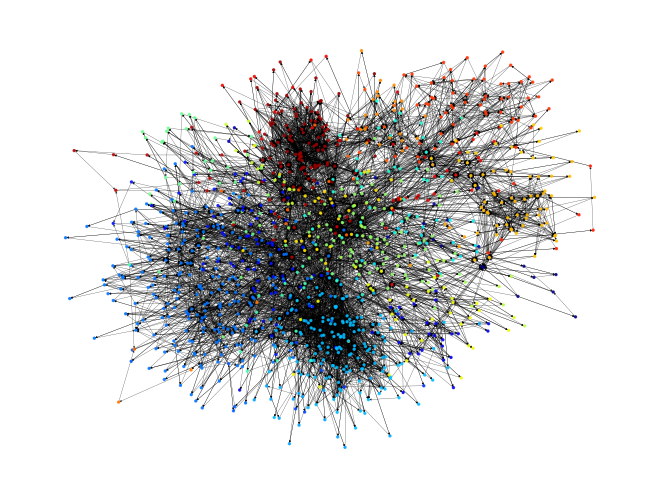

In [16]:
plot_network(rn.graph);

You should now see that the chemical subsystems have been linked together with the zero-cost edges that we just described. This will probably look messy! This is where pathfinding comes in handy.

To get reaction pathways, we simply call the `find_pathways()` method. This automatically handles finding pathways to multiple targets, by calling the internal shortest paths method. The _k_ parameter specifies the number of shortest paths to find to each target. This uses Yen's k-shortest paths algorithm. Here, we use $k=5$ paths per target, however you may want to add more (e.g., 10 or even 15).

In [17]:
paths = rn.find_pathways(["YMnO3", "LiCl", "CO2"], k=5)

Paths to YMnO3 

--------------------------------------- 

3 Li2CO3 + 2 Mn2O3 -> Li3MnO3 + 3 LiMnCO4 (dG = 0.013 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
Total Cost: 0.484 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.082 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
Total Cost: 0.501 

2 YCl3 + 9 Mn2O3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
0.5 Mn2O3 + 0.5 Y2Mn2O7 -> YMnO3 + MnO2 (dG = 0.005 eV/atom) 
Total Cost: 0.528 

2 YCl3 + 9 Mn2O3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.038 eV/atom) 
Total Cost: 0.535 

YCl3 + 5 Mn2O3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> YMnO3 + MnO2 (dG = 0.048 eV/atom) 
Total Cost: 0.535 

Paths to LiCl 

--------------------------------------- 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.036 eV/atom) 
3 Li2O + 2 YCl3 -> Y2O3 + 6 LiCl (dG = -0.319 eV/atom) 
Total Cost: 0.473 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.036 eV/atom) 
Li

The output of this method is a `PathwaySet` object. The set of pathways is composed of individual `BasicPathway` objects. 

In [19]:
example_path = paths.paths[0]
print(example_path)

3 Li2CO3 + 2 Mn2O3 -> Li3MnO3 + 3 LiMnCO4 (dG = 0.013 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
Total Cost: 0.484


**Note: these objects contain a list of reactions and associated costs, but the actual pathway is typically not balanced (i.e. some intermediates are made and never consumed).**

This also means that the reactions you see above do not necessarily include all reactants, nor do they form all desired products. They are simply a series of reactions extracted from the reaction network that may be encountered as the system traverses phase space on its way from precursor(s) to target(s).

To get the balanced reaction pathways, we can use the `PathwaySolver` class. This class takes a `PathwaySet`, the set of entries used in the reaction network, and a cost function. It can be used to solve for balanced pathways given a net reaction. First we initialize the class:

In [20]:
ps = PathwaySolver(paths, rn.entries, cf)

To balance the pathways, we must provide a net reaction representing the total conversion of precursors to final products. This corresponds to the assisted metathesis reaction we defined in the beginning. 

Note: for your own systems where you do not know a net reaction _a priori_, it is logical to make the net reaction's products equal to the set of phases which minimize free energy at the total composition of your system. To do this, one can make a compositional phase diagram and determine the net reaction from there (this is not covered in the notebook here).

We initialize our net reaction here as a `ComputedReaction` object from the corresponding entries. This can be done using the `balance()` constructor and should match the stoichiometry of the overall reaction equation at the top of this notebook.

In [21]:
product_entries = []
for i in ["YMnO3","LiCl","CO2"]:
    product_entries.append(rn.entries.get_min_entry_by_formula(i))
    
net_rxn = ComputedReaction.balance(rn.precursors, product_entries)
net_rxn

1.5 Li2CO3 + YCl3 + 0.5 Mn2O3 -> YMnO3 + 3 LiCl + 1.5 CO2

Finally, we provide the net reaction to the `PathwaySolver` object. The _intermediate_rxn_energy_cutoff_ helps to limit which intermediate reactions are considered (this can substantially decrease the combinatorial complexity), and the _filter_interdependent_ flag verifies that suggested pathways do not contain interdependent reactions. An interdependent pathway is one where 1) the reactants of reaction A depend on the products of the reaction B, and 2) the reactants of reaction B depend on the products of reaction A.

**WARNING**: Even though the code for pathway solving been optimized and parallelized, this is often the most time-intensive step in the reaction network analysis. Consider limiting the value of the maximum number of combos to 5 or less, as well as the value of the intermediate reaction energy cutoff (i.e. < 0.0).

In [22]:
balanced_paths = ps.solve(net_rxn, max_num_combos=4, 
                          intermediate_rxn_energy_cutoff=0.0, 
                          use_minimize_enumerator=False,
                          filter_interdependent=True)

2023-08-31 12:14:02,401 INFO rxn_network.pathways.solver Net reaction: 1.5 Li2CO3 + YCl3 + 0.5 Mn2O3 -> YMnO3 + 3 LiCl + 1.5 CO2 

2023-08-31 12:14:02,402 INFO rxn_network.pathways.solver Identifying reactions between intermediates...


Enumerating reactions (BasicEnumerator): 100%|█| 2/2 [00:00<00:00,  8.66it/s]
Filtering duplicates: 0it [00:00, ?it/s]

2023-08-31 12:14:02,692 INFO rxn_network.pathways.solver Found 47 intermediate reactions! 




Filtering duplicates: 0it [00:00, ?it/s]


2023-08-31 12:14:03,047 INFO rxn_network.pathways.solver Building comp matrices...


100%|██████████████████████████████████████████| 8/8 [00:00<00:00,  9.16it/s]

2023-08-31 12:14:03,923 INFO rxn_network.pathways.solver Comp matrices done...



PathwaySolver (Batch 1/1): 100%|███████████████| 3/3 [00:01<00:00,  1.51it/s]


We can now print the suggested, balanced reaction pathways. These are ordered by an average cost of the total pathway, which is effectively a sum of the indiviudal reaction step costs weighted by their multiplicities (how much of each is required to balance the pathway).

In [23]:
for idx, path in enumerate(balanced_paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
0.5 Mn2O3 + 1.5 Li2CO3 -> 1.5 CO2 + Li3MnO3 (dG = 0.082 eV/atom) 
Average Cost: 0.251


Path 2 

YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.291 eV/atom) 
0.5 Mn2O3 + 0.5 Li2CO3 -> 0.5 CO2 + LiMnO2 (dG = 0.009 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.166 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.081 eV/atom) 
Average Cost: 0.256


Path 3 

YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.291 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.166 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
2 YClO + Li2O -> Y2O3 + 2 LiCl (dG = -0.15 eV/atom) 
Average Cost: 0.258


Path 4 

YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
YCl3 + 2 Li2O -> 3 LiCl + LiYO2 (dG = -0.276 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.166 eV/atom) 
0.6667 Mn2O3 + LiYO2 -> YMnO3 + 0.3333 Li3MnO3 (dG = -0.065 eV/atom) 
Average Cost: 0.263


Path 5 

Mn2O3 + 2 Li2CO3 -> Li2O + 2 LiMnCO4 (dG = 0.036 eV/atom) 
YCl3 + 2 Li2O -> 3 LiCl + LiYO2 (dG = -0.276 eV/atom) 

**It appears that Pathway 2 most closely matches the experimentally observed reaction pathway**. Note that the ordering subject to change in the future with updates to the data / code.

Often times, the suggested pathways will include hypothetical (never-before-synthesized) materials. Here we see this with Li$_3$MnO$_3$ in Pathway 1. 

The top-ranked pathway may not necessarily match what is experimentally observed; if a certain phase is not accessible (perhaps due to kinetic reasons), this may effectively rule out a top pathway from being physically possible. One should also explore different pathway ranking approaches.

## 5. Running networks with jobflow

As was demonstrated in the previous notebook on reaction enumeration, the _reaction-network_ package includes workflows implemented using _jobflow_. 

Below we will briefly demonstrate constructing and running the same analysis as above using the `NetworkFlowMaker`. Reminder: you must have properly configured your jobflow settings in order for this to work. Read more here: https://materialsproject.github.io/jobflow/

**NOTE: if you have set this up such that your `JobStore` lives on a MongoDB (or similar) database, make sure you specify the additional databases `rxns`, `entries`, `paths`, and `network` in your `jobflow.yaml` file!**

In [24]:
from rxn_network.flows.core import NetworkFlowMaker
from rxn_network.jobs.core import NetworkMaker, PathwaySolverMaker
from jobflow.managers.local import run_locally

In [25]:
precursors=["YCl3", "Mn2O3", "Li2CO3"]
targets=["YMnO3", "LiCl", "CO2"]
k=4
temp = 650+273
cf = Softplus(temp)

network_maker = NetworkMaker(cost_function=cf, precursors=precursors, targets=targets, calculate_pathways=k)
solver_maker = PathwaySolverMaker(cost_function=cf, precursors=precursors, targets=targets)

In [26]:
flow = NetworkFlowMaker(network_maker=network_maker, 
                        solver_maker=solver_maker, 
                        use_minimize_enumerators=False).make(precursors=precursors, 
                                                             targets=targets, 
                                                             entries=filtered_entries)

<module 'matplotlib.pyplot' from '/Users/mcdermott/miniconda3/envs/rn_dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

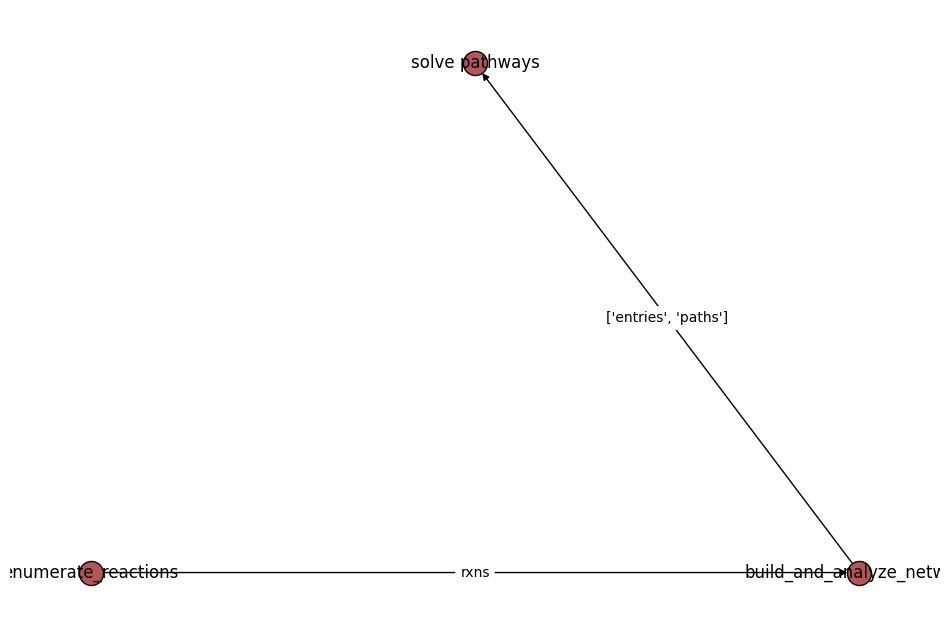

In [27]:
flow.draw_graph()

In [28]:
output = run_locally(flow)

2023-08-31 12:14:06,468 INFO Started executing jobs locally
2023-08-31 12:14:06,473 INFO Starting job - enumerate_reactions (8aaa6cb2-5d86-4f55-91c1-109c92ba5368)
2023-08-31 12:14:06,477 INFO rxn_network.jobs.core Running enumerators...
2023-08-31 12:14:06,478 INFO rxn_network.enumerators.utils Running BasicEnumerator


Building chunks...: 100%|██████████████████| 57/57 [00:00<00:00, 1977.19it/s]
Enumerating reactions (BasicEnumerator): 100%|█| 12/12 [00:01<00:00,  9.45it/

2023-08-31 12:14:07,882 INFO rxn_network.enumerators.utils Adding 2914 reactions to reaction set
2023-08-31 12:14:07,883 INFO rxn_network.enumerators.utils Completed reaction enumeration. Filtering duplicates...



Filtering duplicates: 100%|████████████████| 22/22 [00:00<00:00, 1105.24it/s]

2023-08-31 12:14:07,921 INFO rxn_network.enumerators.utils Completed duplicate filtering.
2023-08-31 12:14:07,921 INFO rxn_network.jobs.core Building task document...


2023-08-31 12:14:08,538 INFO Finished job - enumerate_reactions (8aaa6cb2-5d86-4f55-91c1-109c92ba5368)
2023-08-31 12:14:08,540 INFO Starting job - build_and_analyze_network (8c21f6b8-968b-42fb-941c-a4c44905e520)


Filtering duplicates: 100%|████████████████| 22/22 [00:00<00:00, 1093.66it/s]

2023-08-31 12:14:09,613 INFO rxn_network.network.network Building graph from reactions...



100%|██████████████████████████████████| 2914/2914 [00:01<00:00, 1953.60it/s]


2023-08-31 12:14:11,388 INFO rxn_network.network.network Built graph with 1194 nodes and 3511 edges
Paths to YMnO3 

--------------------------------------- 

3 Li2CO3 + 2 Mn2O3 -> Li3MnO3 + 3 LiMnCO4 (dG = 0.013 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
Total Cost: 0.474 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.082 eV/atom) 
YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
Total Cost: 0.49 

YCl3 + 4.5 Mn2O3 -> Mn8Cl3O10 + 0.5 Y2Mn2O7 (dG = -0.015 eV/atom) 
0.5 Mn2O3 + 0.5 Y2Mn2O7 -> MnO2 + YMnO3 (dG = 0.005 eV/atom) 
Total Cost: 0.516 

YCl3 + 4.5 Mn2O3 -> Mn8Cl3O10 + 0.5 Y2Mn2O7 (dG = -0.015 eV/atom) 
0.5 Y2Mn2O7 -> YMnO3 + 0.25 O2 (dG = 0.038 eV/atom) 
Total Cost: 0.524 

Paths to LiCl 

--------------------------------------- 

Li2CO3 + 0.5 Mn2O3 -> LiMnCO4 + 0.5 Li2O (dG = 0.036 eV/atom) 
2 YCl3 + 3 Li2O -> Y2O3 + 6 LiCl (dG = -0.319 eV/atom) 
Total Cost: 0.462 

Li2CO3 + 0.5 Mn2O3 -> LiMnCO4 + 0.5 Li2O (dG = 0.036 eV/atom) 
YCl3 + Li2O

Enumerating reactions (BasicEnumerator): 100%|█| 1/1 [00:00<00:00,  5.45it/s]
Filtering duplicates: 0it [00:00, ?it/s]

2023-08-31 12:14:33,141 INFO rxn_network.pathways.solver Found 33 intermediate reactions! 




Filtering duplicates: 0it [00:00, ?it/s]

2023-08-31 12:14:33,308 INFO rxn_network.pathways.solver Building comp matrices...



100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.06it/s]

2023-08-31 12:14:34,135 INFO rxn_network.pathways.solver Comp matrices done...



PathwaySolver (Batch 1/1): 100%|███████████████| 3/3 [00:01<00:00,  1.60it/s]


2023-08-31 12:14:36,162 INFO Finished job - solve pathways (a241ea57-e31d-460c-8b40-d3ecafdfe726)
2023-08-31 12:14:36,162 INFO Finished executing jobs locally


Finally, the output from the flow can be accessed as follows:

In [29]:
paths = output[flow.job_uuids[-1]][1].output.balanced_paths

In [30]:
for idx, path in enumerate(balanced_paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
0.5 Mn2O3 + 1.5 Li2CO3 -> 1.5 CO2 + Li3MnO3 (dG = 0.082 eV/atom) 
Average Cost: 0.251


Path 2 

YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.291 eV/atom) 
0.5 Mn2O3 + 0.5 Li2CO3 -> 0.5 CO2 + LiMnO2 (dG = 0.009 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.166 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.081 eV/atom) 
Average Cost: 0.256


Path 3 

YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.291 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.166 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
2 YClO + Li2O -> Y2O3 + 2 LiCl (dG = -0.15 eV/atom) 
Average Cost: 0.258


Path 4 

YCl3 + Li3MnO3 -> YMnO3 + 3 LiCl (dG = -0.228 eV/atom) 
YCl3 + 2 Li2O -> 3 LiCl + LiYO2 (dG = -0.276 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.166 eV/atom) 
0.6667 Mn2O3 + LiYO2 -> YMnO3 + 0.3333 Li3MnO3 (dG = -0.065 eV/atom) 
Average Cost: 0.263


Path 5 

Mn2O3 + 2 Li2CO3 -> Li2O + 2 LiMnCO4 (dG = 0.036 eV/atom) 
YCl3 + 2 Li2O -> 3 LiCl + LiYO2 (dG = -0.276 eV/atom) 

## 6. Conclusion

We hope this notebook was helpful in introducing the `ReactionNetwork` class found in the _reaction-network_ package. If any significant errors are encountered, please first double-check that your settings are configured properly (e.g., proper installation of all dependencies, configuration of your Materials Project API key, etc.). 

If the error persists, then please raise an Issue here: https://github.com/materialsproject/reaction-network/issues

Happy networking!